In [1]:
import pandas as pd
from time import time
import xarray as xr
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy import stats
import matplotlib.patches as mpatches

In [2]:
! aws s3 ls dev-et-data/in/NorthAmerica/

                           PRE ETo/
                           PRE NDVI/
                           PRE PPT/
                           PRE Soil/
                           PRE Temp/
2021-03-11 21:05:58  364931586 global_water_mask_inland.tif


In [3]:
def _get_year_month(product, tif):
    fn = tif.split('/')[-1]
    fn = fn.replace(product,'')
    fn = fn.replace('.tif','')
    fn = fn.replace('_','')
    print(fn)
    return fn

In [4]:
def _file_object(bucket_prefix,product_name,year,day):
    if product_name == 'NDVI':
        file_object = bucket_prefix + 'NDVI/daily_median/' + 'med.{}.250_m_NDVI.tif'.format(day)
    elif product_name == 'pet':
        file_object = bucket_prefix + 'ETo/' + 'pet{}.tif'.format(day)
    elif product_name == 'tavg' or product_name == 'tmax' or product_name == 'tmin':
        variable_prefix = bucket_prefix + 'Temp/daily/' + product_name + '/'
        file_object = variable_prefix  + str(year) + '/' + '{0}_{1}{2}.tif'.format(product_name, year, day)
    elif product_name == 'prec':
        file_object = bucket_prefix + 'PPT/' + str(year) + '/' + '{0}_{1}{2}.tif'.format(product_name, year, day)
    else:
        file_object = bucket_prefix  + str(start_year) + '/' + f'{product_name}_' + str(start_year) + day + '.tif'
    return file_object

In [ ]:
def create_s3_list_of_days_start_end(main_bucket_prefix, start_year,start_day, end_year, end_day, product_name):
    the_list = []
    years = []
    for year in (range(int(start_year),int(end_year)+1)):
        years.append(year)
    if len(years) == 1:
        for i in range(int(start_day),int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
    elif len(years) == 2:
        for i in range(int(start_day),366):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
        for i in range(1,int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,end_year,day)
            the_list.append(file_object)
    else:
        for i in range(int(start_day),366):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
        for year in years[1:-1]:
            for i in range(1,366):
                day = f'{i:03d}'
                file_object = _file_object(main_bucket_prefix,product_name,year,day)
                the_list.append(file_object)
        for i in range(1,int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,end_year,day)
            the_list.append(file_object)
    return the_list

In [ ]:
def xr_build_cube_concat_ds_one(tif_list, product, x, y):
    start = time()
    my_da_list =[]
    year_month_list = []
    for tif in tif_list:
        #tiffile = 's3://dev-et-data/' + tif
        tiffile = tif
        print(tiffile)
        da = xr.open_rasterio(tiffile)
        daSub = da.sel(x=x, y=y, method='nearest')
        #da = da.squeeze().drop(labels='band')
        #da.name=product
        my_da_list.append(daSub)
        tnow = time()
        elapsed = tnow - start
        print(tif, elapsed)
        year_month_list.append(_get_year_month(product, tif))

    da = xr.concat(my_da_list, dim='band')
    da = da.rename({'band':'year_month'})
    da = da.assign_coords(year_month=year_month_list)
    DS = da.to_dataset(name=product)
    return(DS)

In [ ]:
main_bucket_prefix='s3://dev-et-data/in/NorthAmerica/'
start_year = '1999'
start_day = '1'
end_year = '1999'
end_day = '365'
x=-75
y=41

In [ ]:
df_list=[]
for product in ['prec','tavg', 'tmin', 'tmax', 'NDVI', 'pet']:
    print("==="*30)
    print("processing product",product)
    tif_list = create_s3_list_of_days_start_end(main_bucket_prefix, start_year,start_day, end_year, end_day, product)
    print (tif_list)
    ds_pix=xr_build_cube_concat_ds_one(tif_list, product, x, y)
    my_index = ds_pix['year_month'].values
    my_array = ds_pix[product].values
    df = pd.DataFrame(my_array, columns=[product,], index=my_index)
    df_list.append(df)

In [ ]:
df_reset_list = []
for dframe in df_list:
    print (dframe)
    df_reset = dframe.set_index(df_list[0].index)
    print (df_reset)
    df_reset_list.append(df_reset)
df_veget = pd.concat(df_reset_list, axis=1)

df_veget['NDVI'] *= 0.0001
df_veget

In [ ]:
for static_product in ['awc', 'por', 'fc', 'intercept', 'water']:
    if static_product == 'awc' or static_product == 'por' or static_product == 'fc':
        file_object = ['s3://dev-et-data/in/NorthAmerica/Soil/' + '{}_NA_mosaic.tif'.format(static_product)]
    elif static_product == 'intercept':
        file_object = ['s3://dev-et-data/in/NorthAmerica/Soil/' + 'intercept_filled_0_na.tif']
    else:
        file_object = ['s3://dev-et-data/in/NorthAmerica/' + 'global_water_mask_inland.tif']
    ds_pix=xr_build_cube_concat_ds_one(file_object, static_product, x, y)
    df_veget['{}'.format(static_product)] = ds_pix[static_product].values[0]
print (df_veget)

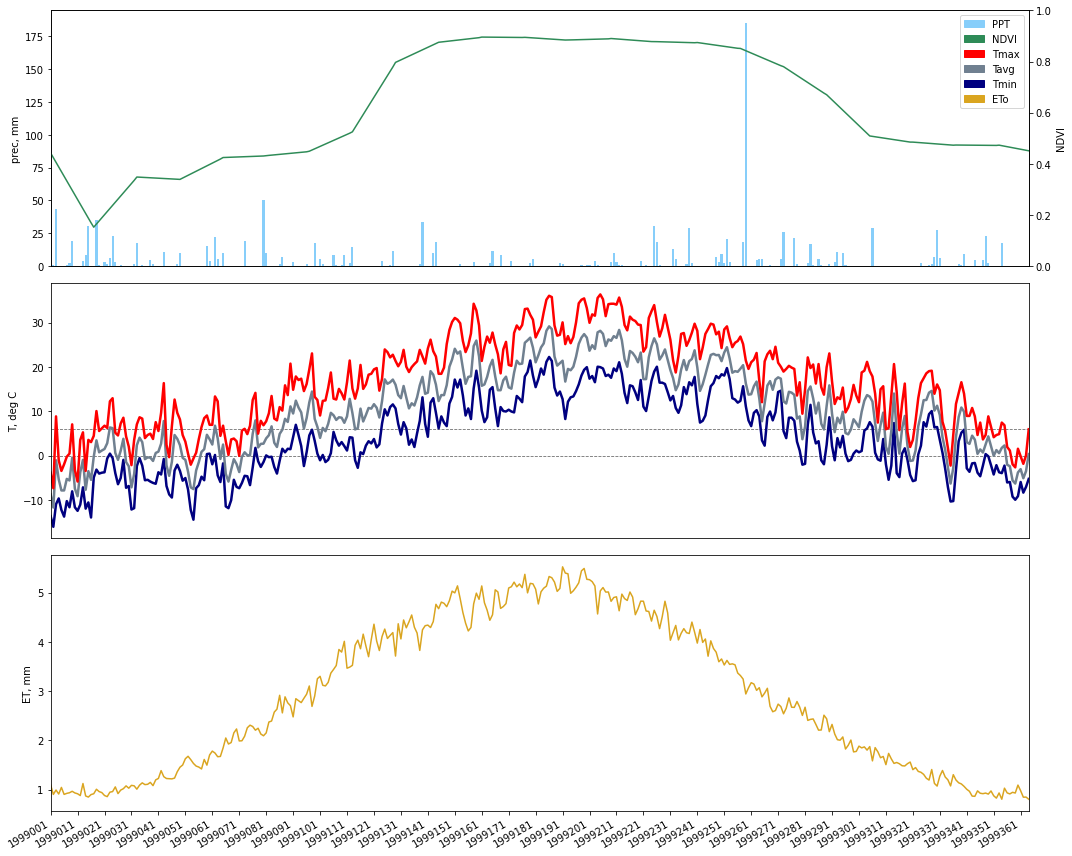

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(15,12))

# first graph - prec and NDVI on two separate axis
axs[0].bar(df_veget.index, df_veget["prec"], color = 'lightskyblue')
ax0 = axs[0].twinx()
ax0.plot(df_veget.index, df_veget["NDVI"], color = 'seagreen')
axs[0].set_ylabel("prec, mm")
ax0.set_ylabel("NDVI")
ax0.set_ylim([0,1])
axs[0].set_xticks([])
ax0.set_xticks([])
axs[0].set_xlim([df_veget.index[0], df_veget.index[-1]])
ax0.set_xlim([df_veget.index[0], df_veget.index[-1]])

# second graph - Tmin, Tavg, Tmax
low_threshold = np.array([0 for i in range(len(df_veget))])
axs[1].plot(df_veget.index, low_threshold,  '--', color = 'dimgray', linewidth=0.8)
high_threshold = np.array([6 for i in range(len(df_veget))])
axs[1].plot(df_veget.index, high_threshold,  '--', color = 'dimgray', linewidth=0.8)
axs[1].plot(df_veget.index, df_veget["tmin"], color = 'navy', linewidth=2.5)
axs[1].plot(df_veget.index, df_veget["tavg"], color = 'slategray', linewidth=2.5)
axs[1].plot(df_veget.index, df_veget["tmax"], color = 'red', linewidth=2.5)
axs[1].set_ylabel("T, deg C")
axs[1].set_xticks([])
axs[1].set_xlim([df_veget.index[0], df_veget.index[-1]])

# third graph - ETo
axs[2].plot(df_veget.index, df_veget["pet"], color = 'goldenrod')
axs[2].set_ylabel("ET, mm")
axs[2].set_xticks(axs[2].get_xticks()[::10])
axs[2].set_xlim([df_veget.index[0], df_veget.index[-1]])

# make a legend based on color inputs
ppt = mpatches.Patch(color='lightskyblue', label='PPT')
ndvi = mpatches.Patch(color='seagreen', label='NDVI')
tmax = mpatches.Patch(color='red', label='Tmax')
tavg = mpatches.Patch(color='slategray', label='Tavg')
tmin = mpatches.Patch(color='navy', label='Tmin')
eto = mpatches.Patch(color='goldenrod', label='ETo')
plt.legend(handles=[ppt, ndvi, tmax, tavg, tmin, eto])

fig.autofmt_xdate()
plt.tight_layout()
#fig.savefig('test.png', dpi=300, format='png', frameon=True)